In [5]:
import pandas as pd
import os
import time
import numpy as np

# start=time.time()
os.chdir('D:\MpEnsystems\Demand Flexibility Project\Modelling\Python model for Generation')
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpStatus

# Define the data

RE_PPA = pd.read_excel('RE power PPA.xlsx')
Solar_pu_cost = RE_PPA.iloc[0,0]
Wind_pu_cost = RE_PPA.iloc[0,1]


demand2 = pd.read_excel('demand.xlsx')   # Demand for each hour
ppa =pd.read_excel('MODCON.xlsx')   # Variable cost for each plant
fixed_cost = ppa['Fixed cost']  # Fixed cost for each plant
Variable_cost=ppa['Variable cost']

ramping_up = 1*ppa['Ramping_up'] # Ramping up limit for each plant
ramping_down =1* ppa['Ramping down']  # Ramping down limit for each plant
generation_capacity=ppa['Capacity'] #generation capacity for each plant
technical_minimum=generation_capacity*0.55 #technical minimum

startup_cost=ppa['Startup cost']
RE_integration =1
RE1=pd.read_excel('RE.xlsx') #RE Power generation
solar=RE_integration*RE1['Solar']
wind=RE_integration*RE1['Wind']



# Solar_pu_cost = float(input('Solar Weighted average cost (INR/kWh): '))
# Wind_pu_cost = float(input('Wind Weighted average cost (INR/kWh): '))

num_plants=len(generation_capacity)
num_hours=len(demand2)

RE=solar+wind
# print(technical_minimum)
demand=demand2['demand']-RE


4.4788473763314745


In [7]:
# Optimisation problem


problem = LpProblem("Power Generation Optimization", LpMinimize)

# Define the decision variables
schedule = [[LpVariable(f"Schedule_{t}_{p}", lowBound=0) for p in range(num_plants)] for t in range(num_hours)]
              

# Set the objective function
problem += lpSum(schedule[t][p] * Variable_cost[p] for t in range(num_hours) for p in range(num_plants))
problem += lpSum(-lpSum(schedule[t][p] for p in range(num_plants))+demand[t] for t in range(num_hours))

# Add the constraints

#ramping up and down constraints 1% for thermal, 3% of gas, 10% of hydro
for t in range(num_hours - 1):
    for p in range(num_plants):
        del_schedule = schedule[t+1][p] - schedule[t][p]
        problem += ramping_down[p] <= del_schedule <= ramping_up[p]
        
# technical Minimum 55%
for t in range(num_hours):
    for p in range(num_plants):
        x=schedule[t][p]
        problem += x>=technical_minimum[p]

    
# Total generation in slot i = Total demand in slot i
for t in range(num_hours):
    problem += lpSum(schedule[t][p] for p in range(num_plants)) ==1* demand[t]
    
# maximum generation limitaion max generation by plant i in any slot < = max generation capacity of plant i 
for t in range(num_hours):
    for p in range(num_plants):
        problem += schedule[t][p] <= ppa['Capacity'][p]

# Solve the problem
problem.solve() 

# Check the status of the solution
print("Status:", LpStatus[problem.status])



# Create a pandas DataFrame to store the schedule
schedule_gen = pd.DataFrame(index=range(num_hours), columns=range(num_plants))


# Populate the DataFrame with the schedule variables value
for t in range(num_hours):
    for p in range(num_plants):
        schedule_gen.at[t, p] = schedule[t][p].varValue

# Write the schedule DataFrame to an Excel file
schedule_df.to_csv("schedule_output.csv", index=False)
end2=time.time()



C:\Users\Kaustubh\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
C:\Users\Kaustubh\anaconda3\lib\site-packages\pulp\pulp.py:1704: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


Status: Optimal


In [13]:
# cost of genration

daily_generation=schedule_gen.sum()*(24/num_hours)

daily_generation_2=schedule_gen.sum(axis=1)

# RE cost
solar_cost=Solar_pu_cost*solar
wind_cost=wind*Wind_pu_cost
RE_cost = solar_cost+wind_cost


# Slot wise total cost / conventional + RE
slot_wise_cost=schedule_gen.dot(np.array(Variable_cost)) +RE_cost

# Slot wise PU cost INR/kWh 
slot_wise_pu=slot_wise_cost/demand


# Generation plant wise variable and fixed cost for given period - Daily/monthly/annually
var_cost_gen =daily_generation*np.array(Variable_cost)
fx_cost_gen=24*generation_capacity*np.array(fixed_cost)
total_cost_gen=np.array(var_cost_gen) + np.array(fx_cost_gen)
pu_cost=total_cost_gen/daily_generation
average_pu_cost = total_cost_gen.sum()/daily_generation.sum()
supply_demand_gap=-np.array(daily_generation_2)+np.array(demand)




<BarContainer object of 96 artists>

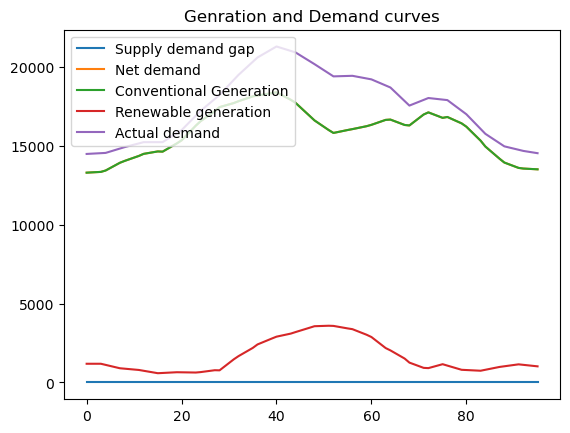

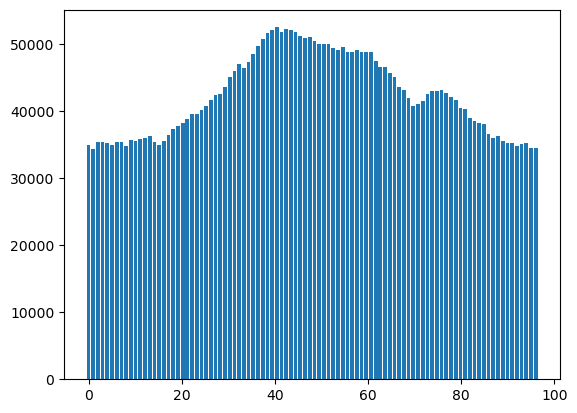

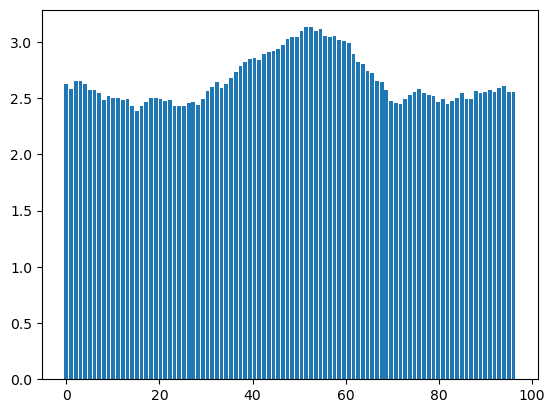

In [26]:
# Graphs

import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(supply_demand_gap,label='Supply demand gap')
plt.plot(demand,label='Net demand')
plt.plot(daily_generation_2,label='Conventional Generation')
plt.plot(RE,label= 'Renewable generation')
plt.plot(demand2['demand'],label='Actual demand')
plt.legend(loc='upper left')
plt.title('Genration and Demand curves')

plf=np.array(daily_generation)/(np.array(24*generation_capacity))



# plt.figure(2)
# x=np.linspace(0,len(pu_cost) ,len(pu_cost))
# plt.bar(x,pu_cost)
# plt.title('Slot wise COST')

# plt.figure(3)
# plt.bar(x,plf)
# plt.title('PLANT PLF')

plt.figure(4)
x=np.linspace(0,len(slot_wise_cost) ,len(slot_wise_cost))
plt.bar(x,slot_wise_cost)

plt.figure(5)
x=np.linspace(0,len(slot_wise_cost) ,len(slot_wise_cost))
plt.bar(x,slot_wise_pu)